# **쇼핑몰 지점별 매출액 예측 경진대회**
- 코드실행은 Google Colab의 CPU, Standard RAM 환경에서 진행했습니다.
- 작성자 : standing-o

## **0. Import Packages**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install flaml
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 9.8 MB/s 
     |████████████████████████████████| 2.0 MB 56.2 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import random as rn
import os
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import norm, skew
import warnings

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from mlxtend.regressor import StackingCVRegressor

from collections import Counter
from flaml import AutoML



%matplotlib inline
warnings.filterwarnings(action='ignore')
%cd '/content/drive/MyDrive/Shopping_sales_revenue'

/content/drive/MyDrive/Shopping_sales_revenue


In [4]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(matplotlib.__version__))
print("scikit-learn version: {}". format(sklearn.__version__))

numpy version: 1.21.6
pandas version: 1.3.5
matplotlib version: 3.2.2
scikit-learn version: 1.0.2


In [5]:
# reproducibility
def seed_all(seed_num):
    rn.seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)
    np.random.seed(seed_num)

seed_num = 42
seed_all(seed_num)

## **1. Load and Check dataset**

In [6]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

print(train.shape)
train.head()

(6255, 13)


,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


## **2. EDA**
- `Weekly_Sales` : 주간 매출액 **(target)**
- `id` : 샘플 아이디 | `Store` : 쇼핑몰 지점 | `Date` : 주 단위(Weekly) 날짜
- `Temperature` : 해당 쇼핑몰 주변 기온 | `Fuel_Price` : 해당 쇼핑몰 주변 연료 가격
- `Promotion 1~5` : 해당 쇼핑몰의 비식별화된 프로모션 정보 | `Unemployment` : 해당 쇼핑몰 지역의 실업률
- `IsHoliday` : 해당 기간의 공휴일 포함 여부

### **Data type**
- Numeric(11) : `id`, `Store`, `Temperature`, `Fuel_Price`, `Promotion1-5`, `Unemployment`, `Weekly_Sales`
- Categorical(1) : `Date`
- Boolean(1) : `IsHoliday`

In [7]:
train.isnull().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

In [8]:
test.isnull().sum()

id                0
Store             0
Date              0
Temperature       0
Fuel_Price        0
Promotion1        2
Promotion2      135
Promotion3       19
Promotion4       34
Promotion5        0
Unemployment      0
IsHoliday         0
dtype: int64

In [70]:
df_train = train.copy()
df_test = test.copy()

### **2-(1). Missing Values**
📝 각 지점 별로 초반에 쭉 이어진 NaN값과 이후의 NaN값을 처리하는 방법을 달리해야할 필요성을 느낍니다.

In [65]:
pros = ['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']
df_train[['Store', 'Date'] + pros][50:100]

,Store,Date,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5
50,1,21/01/2011,NaN,NaN,NaN,NaN,NaN
51,1,28/01/2011,NaN,NaN,NaN,NaN,NaN
52,1,04/02/2011,NaN,NaN,NaN,NaN,NaN
53,1,11/02/2011,NaN,NaN,NaN,NaN,NaN
54,1,18/02/2011,NaN,NaN,NaN,NaN,NaN
55,1,25/02/2011,NaN,NaN,NaN,NaN,NaN
56,1,04/03/2011,NaN,NaN,NaN,NaN,NaN
57,1,11/03/2011,NaN,NaN,NaN,NaN,NaN
58,1,18/03/2011,NaN,NaN,NaN,NaN,NaN
59,1,25/03/2011,NaN,NaN,NaN,NaN,NaN


In [66]:
df_train[['Store', 'Date'] + pros][100:139]

,Store,Date,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5
100,1,06/01/2012,6277.39,21813.16,143.10,1450.13,8483.00
101,1,13/01/2012,5183.29,8025.87,42.24,453.08,3719.38
102,1,20/01/2012,4139.87,2807.19,33.88,500.62,3400.21
103,1,27/01/2012,1164.46,1082.74,44.00,11.00,1222.19
104,1,03/02/2012,34577.06,3579.21,160.53,32403.87,5630.40
105,1,10/02/2012,13925.06,6927.23,101.64,8471.88,6886.04
106,1,17/02/2012,9873.33,11062.27,9.80,8409.31,3402.66
107,1,24/02/2012,9349.61,7556.01,3.20,1219.92,8143.59
108,1,02/03/2012,15441.40,1569.00,10.80,25390.88,8067.61
109,1,09/03/2012,10331.04,151.88,6.00,671.43,5509.84


In [67]:
df_train[['Store', 'Date'] + pros][140:240]

,Store,Date,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5
140,2,12/02/2010,NaN,NaN,NaN,NaN,NaN
141,2,19/02/2010,NaN,NaN,NaN,NaN,NaN
142,2,26/02/2010,NaN,NaN,NaN,NaN,NaN
143,2,05/03/2010,NaN,NaN,NaN,NaN,NaN
144,2,12/03/2010,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
235,2,09/12/2011,11472.59,40.00,306.43,4160.55,8899.08
236,2,16/12/2011,4908.83,61.03,341.49,469.80,4744.27
237,2,23/12/2011,2971.04,15.18,1501.75,88.76,6437.61
238,2,30/12/2011,8321.44,92523.94,139.53,1515.40,3027.69


📝 먼저 유효한 값 사이들로 둘러싸인 NaN값들을 linear interpolation을 통해 채워줍니다.

In [71]:
df_train = df_train.interpolate(methods = 'values', limit_area = 'inside')
df_test = df_test.interpolate(methods = 'values', limit_area = 'inside')
df_test = df_test.fillna(method='bfill')

In [33]:
df_train[['Store', 'Date'] + pros][50:100]

,Store,Date,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5
50,1,21/01/2011,NaN,NaN,NaN,NaN,NaN
51,1,28/01/2011,NaN,NaN,NaN,NaN,NaN
52,1,04/02/2011,NaN,NaN,NaN,NaN,NaN
53,1,11/02/2011,NaN,NaN,NaN,NaN,NaN
54,1,18/02/2011,NaN,NaN,NaN,NaN,NaN
55,1,25/02/2011,NaN,NaN,NaN,NaN,NaN
56,1,04/03/2011,NaN,NaN,NaN,NaN,NaN
57,1,11/03/2011,NaN,NaN,NaN,NaN,NaN
58,1,18/03/2011,NaN,NaN,NaN,NaN,NaN
59,1,25/03/2011,NaN,NaN,NaN,NaN,NaN


In [34]:
df_train[['Store', 'Date'] + pros][100:139]

,Store,Date,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5
100,1,06/01/2012,6277.39,21813.160000,143.10,1450.13,8483.00
101,1,13/01/2012,5183.29,8025.870000,42.24,453.08,3719.38
102,1,20/01/2012,4139.87,2807.190000,33.88,500.62,3400.21
103,1,27/01/2012,1164.46,1082.740000,44.00,11.00,1222.19
104,1,03/02/2012,34577.06,3579.210000,160.53,32403.87,5630.40
105,1,10/02/2012,13925.06,6927.230000,101.64,8471.88,6886.04
106,1,17/02/2012,9873.33,11062.270000,9.80,8409.31,3402.66
107,1,24/02/2012,9349.61,7556.010000,3.20,1219.92,8143.59
108,1,02/03/2012,15441.40,1569.000000,10.80,25390.88,8067.61
109,1,09/03/2012,10331.04,151.880000,6.00,671.43,5509.84


📝 그리고 초반에 쭉 이어지는 NaN값들은 0으로 채워줍니다.

In [72]:
df_train = df_train.fillna(0)

df_train.isnull().sum()

id              0
Store           0
Date            0
Temperature     0
Fuel_Price      0
Promotion1      0
Promotion2      0
Promotion3      0
Promotion4      0
Promotion5      0
Unemployment    0
IsHoliday       0
Weekly_Sales    0
dtype: int64

In [73]:
df_test.isnull().sum()

id              0
Store           0
Date            0
Temperature     0
Fuel_Price      0
Promotion1      0
Promotion2      0
Promotion3      0
Promotion4      0
Promotion5      0
Unemployment    0
IsHoliday       0
dtype: int64

### **2-(2). Visualization**
📝 먼저 target값의 분포를 확인하겠습니다.

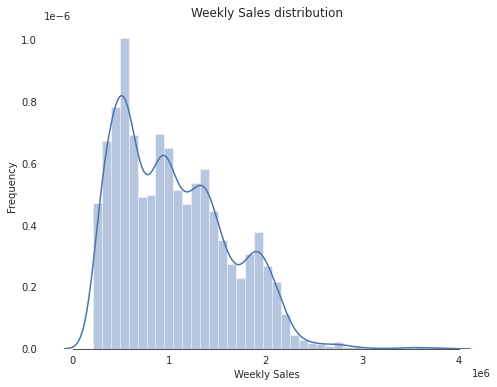

In [36]:
# Before normalization

sns.set_style("white")
sns.set_color_codes(palette = 'deep')
f, ax = plt.subplots(figsize = (8, 6))

sns.distplot(df_train['Weekly_Sales'], color = 'b')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Weekly Sales")
ax.set(title="Weekly Sales distribution")

sns.despine(trim=True, left=True)  # delete border
plt.show()

- 📝 Target값이 왼쪽으로 치우쳐 있습니다.  
- 📝 실제로 train 데이터는 지점(`Store`)별 139개의 주간 시계열 데이터로 이루어져있으며, test 데이터를 통해 각 지점의 2012년 10월의 주간 데이터 (4개)를 예측해야 하는것을 확인할 수 있습니다.

In [37]:
df_train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,False,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87
6251,6252,45,07/09/2012,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66
6252,6253,45,14/09/2012,67.87,3.948,11407.95,52.54,4.30,3421.72,5268.92,8.684,False,702238.27
6253,6254,45,21/09/2012,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20


In [38]:
df_train['Store'].value_counts()

1     139
24    139
26    139
27    139
28    139
29    139
30    139
31    139
32    139
33    139
34    139
35    139
36    139
37    139
38    139
39    139
40    139
41    139
42    139
43    139
44    139
25    139
23    139
2     139
22    139
3     139
4     139
5     139
6     139
7     139
8     139
9     139
10    139
11    139
12    139
13    139
14    139
15    139
16    139
17    139
18    139
19    139
20    139
21    139
45    139
Name: Store, dtype: int64

In [39]:
df_test.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday
0,1,1,05/10/2012,68.55,3.617,8077.89,0.000,18.22,3617.43,3626.14,6.573,False
1,2,1,12/10/2012,62.99,3.601,2086.18,0.000,8.11,602.36,5926.45,6.573,False
2,3,1,19/10/2012,67.97,3.594,950.33,0.000,4.93,80.25,2312.85,6.573,False
3,4,1,26/10/2012,69.16,3.506,2585.85,31.750,6.00,1057.16,1305.01,6.573,False
4,5,2,05/10/2012,70.27,3.617,6037.76,56.255,10.04,3027.37,3853.40,6.170,False


## **3. Feature Engineering**
### **3-(1). `Date`**


In [74]:
df_train['Date']

0       05/02/2010
1       12/02/2010
2       19/02/2010
3       26/02/2010
4       05/03/2010
           ...    
6250    31/08/2012
6251    07/09/2012
6252    14/09/2012
6253    21/09/2012
6254    28/09/2012
Name: Date, Length: 6255, dtype: object

📝 `Date`변수를 datetime 형태로 바꾸겠습니다.

In [75]:
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%d/%m/%Y')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%d/%m/%Y')

df_train['Date']

0      2010-02-05
1      2010-02-12
2      2010-02-19
3      2010-02-26
4      2010-03-05
          ...    
6250   2012-08-31
6251   2012-09-07
6252   2012-09-14
6253   2012-09-21
6254   2012-09-28
Name: Date, Length: 6255, dtype: datetime64[ns]

### **3-(2). `IsHoliday`**
📝 Categorical 데이터를 수치형으로 변환해줍니다.

In [76]:
df_train['IsHoliday'].head()

0    False
1     True
2    False
3    False
4    False
Name: IsHoliday, dtype: bool

In [77]:
df_train = df_train.replace({'IsHoliday' : True}, 1)
df_train = df_train.replace({'IsHoliday' : False}, 0)

df_test = df_test.replace({'IsHoliday' : True}, 1)
df_test = df_test.replace({'IsHoliday' : False}, 0)

In [78]:
df_train['IsHoliday'].head()

0    0
1    1
2    0
3    0
4    0
Name: IsHoliday, dtype: int64

In [79]:
df_test['IsHoliday'].head()

0    0
1    0
2    0
3    0
4    0
Name: IsHoliday, dtype: int64

### **3-(4). Visualization**
📝 모든 수치형 변수의 box plot을 확인했습니다.

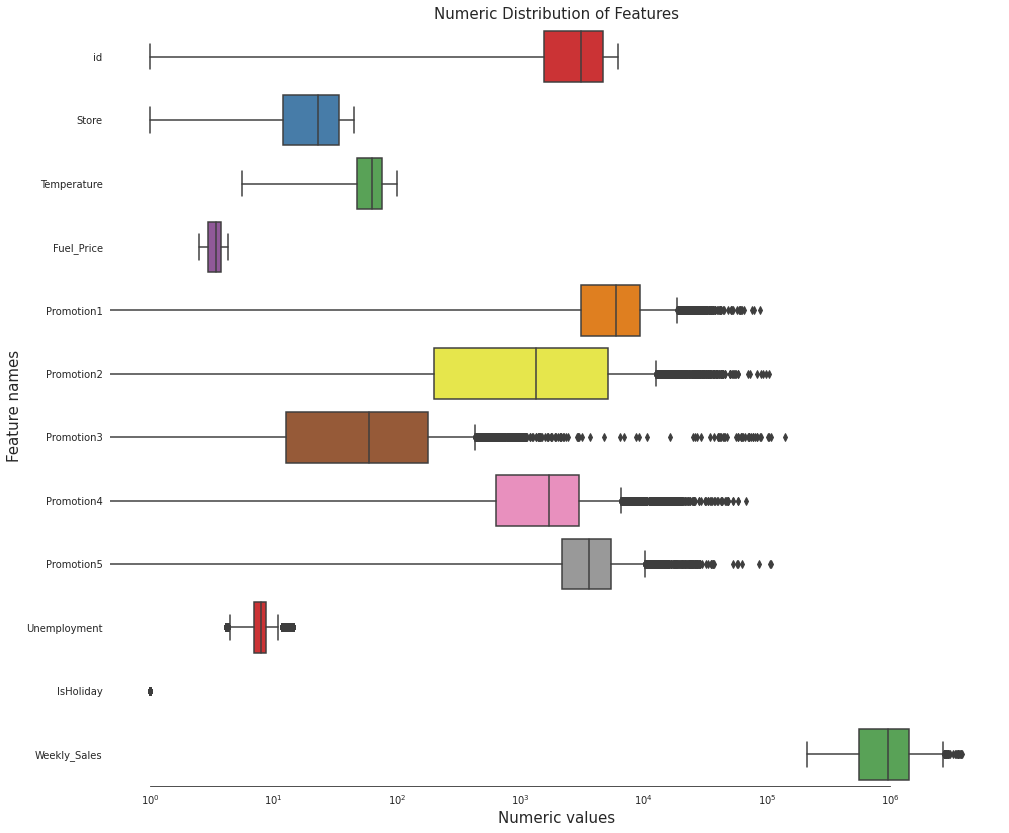

In [80]:
# Box plots for all our numeric features
f, ax = plt.subplots(figsize=(16, 14))
ax.set_xscale("log")

ax = sns.boxplot(data = df_train , orient="h", palette="Set1")

ax.xaxis.grid(False)

plt.xlabel("Numeric values", fontsize = 15)
plt.ylabel("Feature names", fontsize = 15)
plt.title("Numeric Distribution of Features", fontsize = 15)
sns.despine(trim = True, left = True)

In [81]:
train_data = df_train.copy()
test_data = df_test.copy()

## **4. Make dataset**
📝 `Store`별로 데이터를 나눠 `train_1`, ..., `train_45` 변수에 저장하겠습니다.

In [82]:
train_data = train_data.drop(['id', 'Date'], axis = 1)
test_data = test_data.drop(['id', 'Date'], axis = 1)

In [83]:
num_stores = np.max(train_data['Store'])  # 45
num_train_times = 139
num_test_times = 4

In [84]:
for s in range(num_stores):
  globals()['train_{}'.format(s+1)] = train_data.loc[s*num_train_times:((s+1)*num_train_times-1)]

In [85]:
for s in range(num_stores):
  globals()['test_{}'.format(s+1)] = test_data.loc[s*num_test_times:((s+1)*num_test_times-1)]

In [86]:
train_1

,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,0,1643690.90
1,1,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,1,1641957.44
2,1,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,0,1611968.17
3,1,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,0,1409727.59
4,1,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,0,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...
134,1,80.49,3.638,21442.73,102.32,21.70,13209.64,3032.96,6.908,0,1582083.40
135,1,83.96,3.730,5204.68,35.74,50.94,4120.32,2737.17,6.908,1,1661767.33
136,1,74.97,3.717,17212.52,7.00,18.79,1523.11,7992.72,6.908,0,1517428.87
137,1,69.87,3.721,6352.30,7.64,4.69,1010.06,6456.71,6.908,0,1506126.06


In [53]:
train_2

,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
139,2,40.19,2.572,3742.951398,227.396559,6.399140,1453.832151,4744.741075,8.324,0,2136989.46
140,2,38.49,2.548,3819.632796,447.153118,11.148280,1489.704301,4745.202151,8.324,1,2137809.50
141,2,39.69,2.514,3896.314194,666.909677,15.897419,1525.576452,4745.663226,8.324,0,2124451.54
142,2,46.10,2.561,3972.995591,886.666237,20.646559,1561.448602,4746.124301,8.324,0,1865097.27
143,2,47.17,2.625,4049.676989,1106.422796,25.395699,1597.320753,4746.585376,8.324,0,1991013.13
...,...,...,...,...,...,...,...,...,...,...,...
273,2,82.64,3.638,17500.260000,73.220000,21.380000,12878.620000,4756.500000,6.565,0,1947083.30
274,2,87.65,3.730,10658.860000,149.280000,60.970000,2920.900000,3275.570000,6.565,1,1898777.07
275,2,75.88,3.717,8325.930000,76.550000,37.320000,1808.690000,9314.550000,6.565,0,1814806.63
276,2,71.09,3.721,6707.940000,3.820000,15.550000,1001.420000,7607.940000,6.565,0,1829415.67


In [54]:
train_45

,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
6116,45,27.31,2.784,624.737312,1128.086552,27.426526,289.714898,2041.842581,8.992,0,890689.51
6117,45,27.73,2.773,868.514624,1175.059741,29.185368,323.040714,2061.655161,8.992,1,656988.64
6118,45,31.27,2.745,1112.291935,1222.032931,30.944211,356.366531,2081.467742,8.992,0,841264.04
6119,45,34.89,2.754,1356.069247,1269.006121,32.703053,389.692347,2101.280323,8.992,0,741891.65
6120,45,37.13,2.777,1599.846559,1315.979310,34.461895,423.018163,2121.092903,8.992,0,777951.22
...,...,...,...,...,...,...,...,...,...,...,...
6250,45,75.09,3.867,23641.300000,6.000000,92.930000,6988.310000,3992.130000,8.684,0,734297.87
6251,45,75.70,3.911,11024.450000,12.800000,52.630000,1854.770000,2055.700000,8.684,1,766512.66
6252,45,67.87,3.948,11407.950000,52.540000,4.300000,3421.720000,5268.920000,8.684,0,702238.27
6253,45,65.32,4.038,8452.200000,92.280000,63.240000,2376.380000,8670.400000,8.684,0,723086.20


In [87]:
test_1

,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday
0,1,68.55,3.617,8077.89,31.75,18.22,3617.43,3626.14,6.573,0
1,1,62.99,3.601,2086.18,31.75,8.11,602.36,5926.45,6.573,0
2,1,67.97,3.594,950.33,31.75,4.93,80.25,2312.85,6.573,0
3,1,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,6.573,0


In [56]:
test_2

,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday
4,2,70.27,3.617,6037.76,56.255,10.04,3027.37,3853.40,6.17,0
5,2,60.97,3.601,2145.50,80.760,33.31,586.83,10421.01,6.17,0
6,2,68.08,3.594,4461.89,105.265,1.14,1579.67,2642.29,6.17,0
7,2,69.79,3.506,6152.59,129.770,200.00,272.29,2924.15,6.17,0


In [57]:
test_45

,Store,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday
176,45,64.89,3.985,5046.74,16.4775,18.82,2253.43,2340.01,8.667,0
177,45,54.47,4.000,1956.28,30.3450,7.89,599.32,3990.54,8.667,0
178,45,56.47,3.969,2004.02,44.2125,3.18,437.73,1537.49,8.667,0
179,45,58.85,3.882,4018.91,58.0800,100.00,211.94,858.33,8.667,0


## **5. Modeling**
📝 fast automl의 lightgbm을 활용했습니다.

In [58]:
MODEL_TIME_BUDGET = 60*2
MODEL_METRIC = 'rmse'
MODEL_TASK = "regression"
MODEL_LIST = ["xgboost"]

In [59]:
for s in range(num_stores):  # num_stores
  print("Store", s, "get started")
  train_x = globals()['train_{}'.format(s+1)].drop(['Weekly_Sales'], axis = 1)
  train_y = globals()['train_{}'.format(s+1)]['Weekly_Sales']

  globals()['auto_xgb_{}'.format(s+1)] = AutoML()

  params = {
      "time_budget": MODEL_TIME_BUDGET,  
      "metric": MODEL_METRIC,
      "estimator_list": MODEL_LIST, 
      "task": MODEL_TASK,
      "seed":seed_num,
      "verbose":0,
  }

  globals()['auto_xgb_{}'.format(s+1)].fit(train_x, train_y, **params)

Store 0 get started
Store 1 get started
Store 2 get started
Store 3 get started
Store 4 get started
Store 5 get started
Store 6 get started
Store 7 get started
Store 8 get started
Store 9 get started
Store 10 get started
Store 11 get started
Store 12 get started
Store 13 get started
Store 14 get started
Store 15 get started
Store 16 get started
Store 17 get started
Store 18 get started
Store 19 get started
Store 20 get started
Store 21 get started
Store 22 get started
Store 23 get started
Store 24 get started
Store 25 get started
Store 26 get started
Store 27 get started
Store 28 get started
Store 29 get started
Store 30 get started
Store 31 get started
Store 32 get started
Store 33 get started
Store 34 get started
Store 35 get started
Store 36 get started
Store 37 get started
Store 38 get started
Store 39 get started
Store 40 get started
Store 41 get started
Store 42 get started
Store 43 get started
Store 44 get started


In [88]:
pred = []
for s in range(num_stores):  # num_stores
  preds = globals()['auto_xgb_{}'.format(s+1)].predict(globals()['test_{}'.format(s+1)])
  for i in range(4):
    pred.append(preds[i])

In [89]:
print(pred)
print(np.shape(pred))

[1554298.6, 1579644.9, 1554298.6, 1554298.6, 1874394.8, 2021729.4, 1794570.4, 1981722.8, 414666.34, 413664.22, 388637.9, 352002.38, 2080186.1, 2079192.9, 2084358.2, 2253354.2, 316230.53, 318794.88, 318794.88, 293269.06, 1399105.5, 1485482.6, 1483559.6, 1549006.8, 584254.4, 626234.06, 577697.44, 646129.75, 912653.0, 850020.75, 880646.44, 930469.4, 544141.8, 584458.06, 529911.56, 559892.1, 1811543.9, 1787419.1, 1782349.5, 1774888.8, 1329185.6, 1366549.6, 1380645.4, 1405411.4, 992879.94, 997114.25, 989066.56, 1074706.0, 2001374.5, 2034038.8, 2034038.8, 2039039.0, 1747605.6, 1725216.0, 1775643.5, 1758835.4, 530721.6, 546794.0, 518802.16, 640639.9, 454451.16, 512526.2, 517978.9, 523956.8, 949513.44, 1101347.4, 1085124.1, 942883.8, 1033720.0, 991065.25, 991065.25, 1033720.0, 1361548.8, 1520244.0, 1311512.4, 1311512.4, 1999276.2, 2124650.8, 1997714.1, 2047078.2, 718343.9, 690371.4, 721201.94, 743604.94, 857732.25, 1012380.1, 902717.3, 992870.75, 1422807.1, 1383711.1, 1288172.2, 1590552.0, 129

In [90]:
# make submission
sample_submission = pd.read_csv('dataset/sample_submission.csv')
sample_submission['Weekly_Sales'] = pred
sample_submission.to_csv('4_handle_store_pro_xgb2.csv',index = False)